In [49]:
# Turn on autoreload so code changes are automatically added.
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

In [50]:
# Imports
import numpy as np
import visualizers as viz
import util as ut
from scipy.spatial.transform import Rotation

In [51]:
# Variable Params
tf = 10.0                                   # final time (per trajectory)
zA = 1.5                                   # altitude for ALL points
xt = 0.1                                    # further x point (the tip)
qA = np.array([1.00, 0.00, 0.00, 0.00])     # orientation for ALL points
psi_off = 0*np.pi/3                           # Yaw offset
d_off = 5                                   # distance offset (l2-norm from target)

# Fixed Params
hz = 20        


In [52]:
# # Line =======================================

# # Generate Trajectory
# T = np.linspace(0.0,tf,hz)
# N = int(tf*hz+1)
# Nhf = ((N-1)//2)

# x1 = np.linspace(0,xt,Nhf+1)
# x2 = np.flip(x1)

# X = np.zeros((13,N))
# X[0,:] = np.hstack((x1,x2[1:]))
# X[2,:] = zA
# X[6:10,:] = qA.reshape((4,1))


In [53]:
# Selfie =======================================

# Useful Stuff
tw = np.array([0.00,0.00,1.00])
c0 = np.array([0.00,0.00,0.00]).reshape((3,1))
c1 = np.array([0.00,0.00,0.00,1.00])
N = int(tf*hz+1)
Nhf = ((N-1)//2)

# Outputs
T = np.linspace(0.0,tf,N)
X = np.zeros((13,N))

# Generate Position
x1 = np.linspace(0,xt,Nhf+1)
x2 = np.flip(x1)

pos = np.zeros((3,N))
pos[0,:] = np.hstack((x1,x2[1:]))
pos[2,:] = zA

# Generate Yaw
x2d = pos[:2, :]
x_off = xt/2
y_off = -np.sqrt(d_off**2-x_off**2)
p = np.array([x_off, y_off]).reshape(2, 1)

d = p - x2d
yaw = np.arctan2(d[1, :], d[0, :])

# Account for Global Yaw Transform
R_off = Rotation.from_euler("z", psi_off).as_matrix()
H_off = np.vstack((np.hstack((R_off,c0)),c1))

for idx, psi in enumerate(yaw):
    xc = np.array([ np.cos(psi), np.sin(psi), 0.0 ])
    yc = np.array([-np.sin(psi), np.cos(psi), 0.0 ])

    xb = ut.cross(yc,tw)/np.linalg.norm(ut.cross(yc,tw))
    yb = ut.cross(tw,xb)/np.linalg.norm(ut.cross(tw,xb))
    zb = ut.cross(xb,yb)

    Rb = np.hstack((xb.reshape(3,1), yb.reshape(3,1), zb.reshape(3,1)))
    Hb = np.vstack((np.hstack((Rb,pos[:,idx].reshape((3,1)))),c1))

    Ho = H_off@Hb
    xo = Ho[0:3,3]
    qo = ut.rotm2quat(Ho[0:3,0:3])

    X[0:3,idx] = xo
    X[6:10,idx] = qo


In [54]:
# # from scipy.spatial.transform import Rotation
# x2d = X[:2, :]
# p = np.array([2.5, -4.0]).reshape(2, 1)
# d = p - x2d
# yaw = np.arctan2(d[1, :], d[0, :])

# tw = np.array([0.00,0.00,1.00])

# rot_offset = np.pi / 4 * np.ones_like(yaw)
# R_offset = Rotation.from_euler("z", rot_offset).as_matrix()

# Rs = Rotation.from_euler("z", yaw).as_matrix()
# H = np.zeros((Rs.shape[0], 4, 4))
# H[:, :3, :3] = Rs
# H[:, :3, 3] = X[:3, :].T
# H[:, 3, 3] = 1.0

# H_offset = np.zeros_like(H)
# H_offset[:, :3, :3] = R_offset
# H_offset[:, 3, 3] = 1.0

# Hf = H_offset @ H

# X[:3, :] = Hf[:, :3, 3].T
# X[6:10, :] = np.array([ut.rotm2quat(R) for R in Hf[:, :3, :3]]).T

# # for idx, psi in enumerate(yaw):
# #     xc = np.array([ np.cos(psi), np.sin(psi), 0.0 ])
# #     yc = np.array([-np.sin(psi), np.cos(psi), 0.0 ])

# #     xb = ut.cross(yc,tw)/np.linalg.norm(ut.cross(yc,tw))
# #     yb = ut.cross(tw,xb)/np.linalg.norm(ut.cross(tw,xb))
# #     zb = ut.cross(xb,yb)

# #     R = np.hstack((xb.reshape(3,1), yb.reshape(3,1), zb.reshape(3,1)))

# #     q = ut.rotm2quat(R)
# #     X[6:10,idx] = q

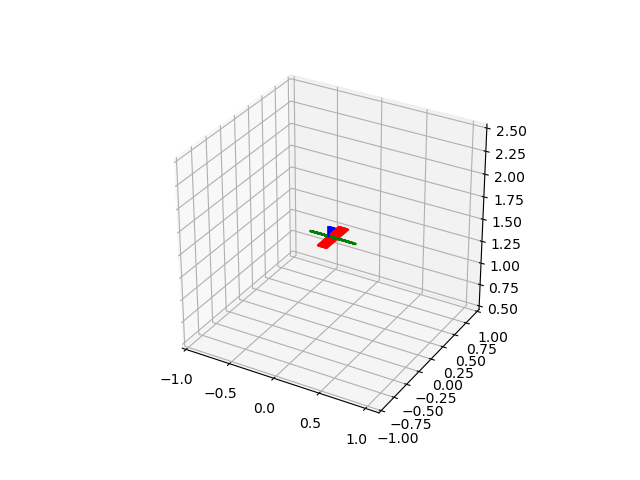

In [55]:
# Visualize
viz.trajviz([X],step=5)
# viz.trajanimate(X,X)

In [56]:
traj = np.vstack((T,X))
np.savetxt("selfie.csv", traj, delimiter=",")
